In [50]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
%matplotlib inline

### Single Model Evaluation Characteristics

In [61]:
'''
save_path = path ofr saving report
y_preds = predicted output
y_targets = actual values
num_classes = total number of classes
class_map_dict = dictionary mapping for classes
'''

def save_classification_report(path, model_name, y_preds, y_targets, class_map_dict):
    path = os.path.join(path, 'classification_report.png')
    # get classification report
    cr = classification_report(y_targets, y_preds, target_names=list(class_map_dict.values()))

     # plot report
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')
    ax.text(0.1, 0.5, cr, fontsize=10, va='center', ha='left', family='monospace')
    plt.title(f'{model_name}')
    plt.savefig(path, bbox_inches='tight', dpi=300)


def save_confusion_matrix(path, model_name, y_preds, y_targets, class_map_dict):
    path = os.path.join(path, 'confusion_matrix.png')
    cm = confusion_matrix(y_targets, y_preds, labels=list(class_map_dict.keys()))
    cm_ratio = cm / cm.sum(axis=1, keepdims=True)

    # Create a heatmap
    sns.set()
    plt.figure(figsize=(len(class_map_dict) + 2, len(class_map_dict)))


    heatmap = sns.heatmap(cm_ratio, annot=True, cmap="GnBu", fmt=".2f",
                          cbar=False, xticklabels=class_map_dict.values(),
                          yticklabels=class_map_dict.values())

    plt.title(f"Confusion Matrix Percentages or {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(path, bbox_inches='tight', dpi=300)


# one vs all auc score and accuracy for model
def save_average_auc_acc_score(path, model_name, y_preds, y_targets):
    fname = f'ovr_auc_{model_name}.json'
    path = os.path.join(path, fname)
    auc = roc_auc_score(y_targets, y_preds, average=None, multi_class='ovr')
    acc = accuracy_score(y_targets, y_preds)
    score_dict = {'ovr_auc' : auc,
                 'accuracy': acc}

    # Save the dictionary as a JSON file
    with open(path, 'w') as json_file:
        json.dump(score_dict, json_file, indent=4)


# evaluation report for a single model
def create_model_evaluation_report(dest_path, model_name, y_preds, y_targets, class_map_dict):

    # create directory
    dir_path = os.path.join(dest_path, model_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # create classification report
    save_classification_report(dir_path, model_name, y_preds, y_targets, class_map_dict)

    # create confusion matrix
    save_confusion_matrix(dir_path, model_name, y_preds, y_targets, class_map_dict)

    # save one vs rest average auc score
    save_average_auc_acc_score(dir_path, model_name, y_preds, y_targets)

    print(f'Model evaluation reports saved for {model_name} at {dir_path}.\n')

### Multi-Model Evaluation Characteristics

In [74]:
'''
true_labels = true values (1D array)
predicted_values_list = predicted values for each model (2D array)
model_names_dict = dictionary mappling for legend information
comparison_class_idx = positice class for soing one vs all roc compuation
'''

def save_roc_curve(dir_path, true_labels, predicted_values_list, model_names_dict, n_classes,
                   comparison_class_idx, comparison_class_name):

    path = os.path.join(dir_path, f'{comparison_class_name}_ROC_Curve.jpeg')
    plt.figure(figsize=(8, 8))
    # transform true_labels
    trans_true_labels = (true_labels == comparison_class_idx).astype(np.int8)
    for model_index, predicted_values in enumerate(predicted_values_list):
        model_name = model_names_dict[model_index]
        trans_pred_labels = (predicted_values_list[model_index]  == comparison_class_idx).astype(np.int8)
        fpr, tpr, _ = roc_curve(trans_true_labels, trans_pred_labels)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_names_dict[model_index]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve Comparison for '{comparison_class_name}' classification")
    plt.legend()
    plt.savefig(path, bbox_inches='tight', dpi=300)


In [65]:
def generate_fake_classification_results(n, n_classes):
    # Generate random predicted values for n_classes
    preds = []
    preds.append(np.random.randint(0, n_classes, size=n))
    preds.append(np.random.randint(0, n_classes, size=n))
    preds.append(np.random.randint(0, n_classes, size=n))

    # Generate corresponding true values
    true_values = np.random.randint(0, n_classes, size=n)

    # Calculate accuracy for each class
    model_accuracies = []
    for i in range(3):
        class_accuracies = []
        for class_label in range(n_classes):
            class_mask = (true_values == class_label)
            class_accuracy = accuracy_score(true_values[class_mask], preds[i][class_mask])
            class_accuracies.append(class_accuracy)
        model_accuracies.append(class_accuracies)

    return preds, true_values, model_accuracies

In [73]:
n_instances = 100
num_classes = 5

class_map_dict = {0: 'class_0',
                  1: 'class_1',
                  2: 'class_2',
                  3: 'class_3',
                  4: 'class_4'}

model_names = {0: 'Model1', 1: 'Model2', 2: 'Model3', 3: 'Model4', 4: 'Model5'}

Y_preds, y_targets, accuracies = generate_fake_classification_results(n_instances, num_classes)
print(accuracies)

[[0.17647058823529413, 0.4, 0.05555555555555555, 0.2, 0.16], [0.23529411764705882, 0.26666666666666666, 0.05555555555555555, 0.2, 0.2], [0.29411764705882354, 0.26666666666666666, 0.2222222222222222, 0.08, 0.04]]


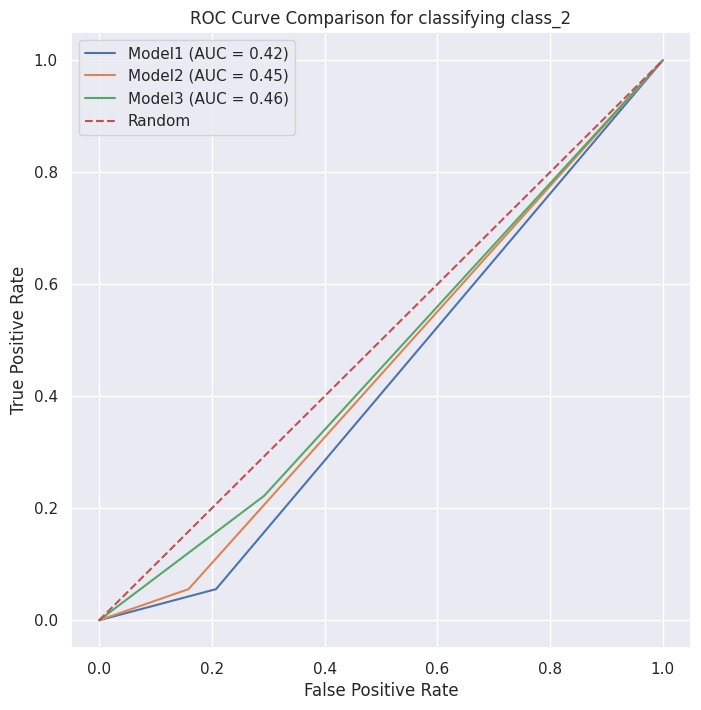

In [75]:
plot_roc_curve(y_targets, Y_preds, model_names, 5, 2, class_map_dict[2])

In [67]:
a = np.array([1,2,3,1,4,5,4])
a

array([1, 2, 3, 1, 4, 5, 4])

In [70]:
(a == 4).astype(np.int8)

array([0, 0, 0, 0, 1, 0, 1], dtype=int8)